In [ ]:
'''
Remember always to check the vignetted-corrected, bkg-subtracted images first before making sb profiles!
(the image creating script is at the end of this file)
'''

In [5]:
import numpy as np
# import pyproffit
import matplotlib.pyplot as plt
import os
from astropy.io import fits

workpath = '/stage/headat/yanling/xmm/reduction_230227/merged/2023-05-11'
os.chdir(workpath)
os.getcwd()

'/stage/headat/yanling/xmm/reduction_230227/merged/2023-05-11'

In [ ]:
def DoubleBeta(x, beta, rc1, rc2, ratio, norm, const):
    out = np.power(10,norm) * (np.power(1 + (x / rc1) **2, -3 * beta + 0.5) + ratio * np.power(1 + (x / rc2) **2, -3 * beta + 0.5)) + np.power(10,const)
    return out
def BetaModel(x, beta, rc, norm,const):
    out = norm * np.power(1. + (x / rc) ** 2, -3. * beta + 0.5) + const
    return out

In [ ]:
beta = 42.068108; rc1 = 10.888732/60; rc2 =  30.13499/60; ratio = 0.23852488; norm = 3.9734867e-05; const = 4.24e-07
x = np.logspace(-3, 1, 100)
y = DoubleBeta(x, beta, rc1, rc2, ratio, norm, const)

plt.plot(x,y)
plt.xscale('log')
plt.yscale('log')

In [ ]:
datapath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302'
radec_lst = {'A222':[24.3941937, -12.9933436], "A223":[24.4830446, -12.8203439]}
doublebeta_para = {'0.5-7':[0.6, 1, 7, 0.23852488, -4, -6],
 "0.7-1.2":[0.6, 1, 7, 0.2, -5, -6]}
for ins in [ 'xmm']:#,'xmm','chandra'
    for band in ['0.5-7']:#, 
        for clus in ['A222',  'A223']:
            ra = radec_lst[clus][0]
            dec = radec_lst[clus][1]
            print(f'{ins}, {band}, {clus}, {ra}, {dec}')
            path = f'{datapath}/{ins}'
            if ins=='chandra':
                # reg = f'{path}/wavdetect_merge_clean_withexp_src_fk5.reg'
                img = f'{path}/images/{band}_band1_thresh.fits'
                # exp = f'{path}/images/0.5-7_band1_thresh_srcmsk_expmap.fits'
                exp = f'{path}/images/{band}_band1_thresh_srcmsk_{clus}filamsk_expmap_edgemsk.fits'
                bkg = f'{path}/images/{band}_band1_nxb_scaled.fits'
            elif ins=='xmm':
                # reg = f'{path}/EPIC_src_edit_man_fk5.reg'
                if band =='0.5-7':
                    img = f'{path}/{band}/EPIC_cts.fits'
                    # exp = f'{path}/{band}/EPIC_exp_srcmsk.fits'
                    exp = f'{path}/{band}/EPIC_exp_{clus}filamsk_srcmsk.fits'
                    bkg = f'{path}/{band}/EPIC_bkg.fits'
                elif band =='0.7-1.2':
                    img = f'{path}/{band}/EPIC_cts_700-1200.fits'
                    exp = f'{path}/{band}/EPIC_exp_700-1200_{clus}filamsk_srcmsk.fits'
                    bkg = f'{path}/{band}/EPIC_bkg_700-1200.fits'

            # # for nw region only
            # exp = f'{path}/0.5-7/EPIC_exp_A223_nw_xmm_exp.fits'
            dat=pyproffit.Data(imglink=img,explink=exp,bkglink=bkg)
            # fig = plt.figure(figsize=(6,6))
            # s1=plt.subplot(221)
            # plt.imshow(np.log10(dat.img),aspect='auto')
            # print(dat.img.max(), dat.img.min())
            # print(dat.bkg.max(), dat.bkg.min())
            # print((dat.img-dat.bkg).min(), (dat.img-dat.bkg).max())
            # s2=plt.subplot(222)
            # plt.imshow(dat.exposure,aspect='auto')
            
            prof=pyproffit.Profile(dat, center_choice='custom_fk5', center_ra = ra, center_dec =dec, maxrad=20., binsize=6, binning='log')
            prof.SBprofile(ellipse_ratio=1)#, angle_low=80, angle_high=140)

            # ## Beta
            # mod=pyproffit.Model(pyproffit.BetaModel)
            # fitobj=pyproffit.Fitter(model=mod, method='cstat', profile=prof, beta=0.6, rc=1, norm=-2, bkg=-2, fitlow=0., fithigh=10.)

            ### Double Beta
            mod=pyproffit.Model(pyproffit.DoubleBeta)
            beta, rc1,rc2, ratio, norm, bkg = doublebeta_para[band]
            fitobj=pyproffit.Fitter(model=mod, method='cstat', profile=prof, beta = beta, rc1 = rc1, rc2 =  rc2, ratio = ratio, norm = norm, bkg=bkg, fitlow=0.1, fithigh=20.)


            fitobj.Migrad()
            prof.Plot(model=mod)
            plt.title(f'{ins}, {band}, {clus}, {ra}, {dec}')

            # # inspecting results
            # # fitobj.minuit.minos()
            # #fitobj.minuit.draw_mncontour('beta', 'rc', cl=(0.68, 0.9, 0.99))
            os.makedirs(f'{datapath}/png', exist_ok=True)
            plt.savefig(f'{datapath}/png/A223_nw_{ins}_{clus}_{band}.pdf', dpi=300)
            # prof.Save(outfile=f"/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230305/{clus}_{ins}_{band}_doublebeta_profile_inclfila.fits", model=mod)


plot only emos

In [ ]:
datapath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230422'
radec_lst = {'A222':[24.3941937, -12.9933436], "A223":[24.4830446, -12.8203439]}
doublebeta_para = {"700-1200":[0.6, 1, 7, 0.2, -3, -4], "1200-2000":[0.6, 1, 7, 0.2, -3, -4], "2000-5000":[0.6, 1, 7, 0.2, -2, -4], "5000-7000":[0.6, 1, 7, 0.2, -2, -4]}
for ins in ['EMOS', 'EPIC']:#,'xmm','chandra'
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:#, 
        for clus in ['A222',  'A223']:
            ra = radec_lst[clus][0]
            dec = radec_lst[clus][1]
            img = f'{ins}_cts_{band}.img'
            exp = f'{ins}_exp_{band}_srcmsk_{clus}filamsk_expmap.fits'
            bkg = f'{ins}_bkg_{band}.img'      

            dat=pyproffit.Data(imglink=img, explink=exp, bkglink=bkg)
            prof=pyproffit.Profile(dat, center_choice='custom_fk5', center_ra = ra, center_dec =dec, maxrad=20., binsize=6, binning='log')
            prof.SBprofile(ellipse_ratio=1)#, angle_low=80, angle_high=140)
            
            ### Double Beta
            mod=pyproffit.Model(pyproffit.DoubleBeta)
            beta, rc1,rc2, ratio, norm, bkg = doublebeta_para[band]
            fitobj=pyproffit.Fitter(model=mod, method='cstat', profile=prof, beta = beta, rc1 = rc1, rc2 =  rc2, ratio = ratio, norm = norm, bkg=bkg, fitlow=0.1, fithigh=20.)
            
            fitobj.Migrad()
            prof.Plot(model=mod)
            plt.title(f'{ins}, {band}, {clus}, {ra}, {dec}')

            # # inspecting results
            # # fitobj.minuit.minos()
            # #fitobj.minuit.draw_mncontour('beta', 'rc', cl=(0.68, 0.9, 0.99))
            os.makedirs(f'{datapath}/png', exist_ok=True)
            plt.savefig(f'{datapath}/png/{ins}_{clus}_{band}.pdf', dpi=300)
            prof.Save(outfile=f"/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230422/{clus}_{ins}_{band}_doublebeta_profile_inclfila.fits", model=mod)


plot obs and ins separately
1. mask the exp edge with 10arcmin circle centered on aimpoint
2. do the fitting and plot separately
3. merge
4. fit and plot the merged images


# make masks for expmap

In [ ]:
from glob import glob
today = '2023-05-11'
workpath = f'/stage/headat/yanling/xmm/reduction_230227/merged/2023-05-11'
# os.makedirs(f'{workpath}/masks', exist_ok=True)
# os.system(f'cp {workpath}/../2023-05-04/masks/*reg {workpath}/masks')
f = open(f'{workpath}/masks/make_masks_{today}.sh', 'w')
for obs in [101,201]:
    for ins in ['EMOS1', 'EMOS2', 'EPN']: # 
        for type in ['cts', 'bkg', 'exp']:
            files = glob(f'{workpath}/{ins}_exp_obs{obs}*.img')
            for file in files:
                f.write(f"ftimgcalc {workpath}/masks/{file.split('/')[-1]}_edgemsk.fits 'regfilter(\"{workpath}/masks/{ins}_obs{obs}_edgemsk.reg\",A.P1,A.P2) ? (1):(0)' a={file} clobber=yes\n")
                f.write(f"ftimgcalc {workpath}/masks/{file.split('/')[-1]}_srcmsk.fits 'regfilter(\"{workpath}/masks/EPIC_src_edit_man_fk5_1e-6.reg\",A.P1,A.P2) ? (0):(1)' a={file} clobber=yes\n")
                for clus in ['A222', 'A223']:
                    f.write(f"ftimgcalc {workpath}/masks/{file.split('/')[-1]}_{clus}_filamsk.fits 'regfilter(\"{workpath}/masks/{clus}_filamsk_xmm.reg\",A.P1,A.P2) ? (0):(1)' a={file} clobber=yes\n")

f.close()

# sh masks/make_masks*.sh

mask edge, filamsk, sources from the data, bkg, exp maps

In [ ]:
from glob import glob

today = '2023-05-11'
f = open(f'masks/mask_data_bkg_{today}.sh', 'w')
f.write('#!/bin/bash\n')
for obs in [101,201]:
    for ins in ['EMOS1', 'EMOS2', 'EPN']: # 
        for type in ['cts', 'bkg', 'exp']:
            files = glob(f'{ins}_{type}_obs{obs}*.img')
            for file in files:
                f.write(f"farith masks/{file.split('/')[-1]}_edgemsk.fits {file} {file.split('/')[-1].split('.')[0]}_{today}_edgemsk.fits '*' clobber=yes\n")
                f.write(f"farith {file.split('/')[-1].split('.')[0]}_{today}_edgemsk.fits masks/{file.split('/')[-1]}_srcmsk.fits {file.split('/')[-1].split('.')[0]}_{today}_edgemsk_srcmsk.fits '*' clobber=yes\n")
                for clus in ['A222', 'A223']:
                    f.write(f"farith masks/{file.split('/')[-1]}_{clus}_filamsk.fits {file.split('/')[-1].split('.')[0]}_{today}_edgemsk_srcmsk.fits {file.split('/')[-1].split('.')[0]}_{today}_edgemsk_srcmsk_{clus}_filamsk.fits '*' clobber=yes\n")
f.close()

scale PN expmap

In [ ]:
# from PIMMS
PN_scaling  = {'700-1200':[2.137, 7.92] , '700-2000':[2.024, 6.374] , 
'700-7000': [0.9817,2.916], '2000-7000': [0.5469, 1.474], '5000-7000': [2.547, 8.651], 
'2000-5000': [0.7015, 1.797], '1200-7000': [0.812, 2.181], '1200-2000': [1.937, 5.183]}

PN_scales = {}
for band in PN_scaling.keys():
    PN_scales[band] = PN_scaling[band][1]/PN_scaling[band][0]
print(PN_scales)


In [ ]:
f = open('scale_PN_expmap.sh', 'w')
for obs in [101,201]:
    files = glob(f'EPN_exp_obs{obs}_*-*_{today}*.fits')
    for file in files:
        f.write(f'fcarith {file} {PN_scales[band]} {file.split(".")[0]}_scaled.fits "*" clobber=yes\n')
f.close()

Use zhtools to merge exp images

In [ ]:
f = open(f'merge_inst_zhtools.sh', 'w')
date2 = '2023-05-05'
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
    for type in ['edgemsk', 'edgemsk_srcmsk', 'edgemsk_srcmsk_A222_filamsk', 'edgemsk_srcmsk_A223_filamsk']:
        for file in files:
            f.write(f'addimages EMOS1_exp_obs101_{band}_{date2}_{today}_{type}.fits EMOS1_exp_obs201_{band}_{date2}_{today}_{type}.fits EMOS2_exp_obs101_{band}_{date2}_{today}_{type}.fits EMOS2_exp_obs201_{band}_{date2}_{today}_{type}.fits EMOS_exp_{band}_{today}_{type}.fits\n')
            f.write(f'addimages EPN_exp_obs101_{band}_{today}_{type}_scaled.fits EPN_exp_obs201_{band}_{today}_{type}_scaled.fits EPN_exp_{band}_{today}_{type}.fits\n')
            f.write(f'addimages EMOS_exp_{band}_{today}_{type}.fits EPN_exp_{band}_{today}_{type}.fits EPIC_exp_{band}_{today}_{type}.fits\n')
f.close()

use zhtools to merge bands

In [ ]:
f = open(f'merge_bands_zhtools.sh', 'w')
for type in ['edgemsk', 'edgemsk_srcmsk', 'edgemsk_srcmsk_A222_filamsk', 'edgemsk_srcmsk_A223_filamsk']:
    for inst in ['EMOS', 'EPN', 'EPIC']:
        for type in ['counts', 'bkg']:
            f.write(f'addimages {inst}_{type}_1200-2000_{today}.fits {inst}_{type}_2000-5000_{today}.fits {inst}_{type}_5000-7000_{today}.fits {inst}_{type}_1200-7000_{today}.fits expand=no\n')
            f.write(f'addimages {inst}_{type}_700-1200_{today}.fits {inst}_{type}_1200-2000_{today}.fits {inst}_{type}_700-2000_{today}.fits expand=no\n')
            f.write(f'addimages {inst}_{type}_2000-5000_{today}.fits {inst}_{type}_5000-7000_{today}.fits {inst}_{type}_2000-7000_{today}.fits expand=no\n')
f.close()


In [ ]:
f = open(f'merge_bands_zhtools_exp.sh', 'w')
for type in ['edgemsk', 'edgemsk_srcmsk', 'edgemsk_srcmsk_A222_filamsk', 'edgemsk_srcmsk_A223_filamsk']:
    for inst in ['EMOS', 'EPN', 'EPIC']:
        for type in ['exp']:
            for type1 in ['edgemsk', 'edgemsk_srcmsk', 'edgemsk_srcmsk_A222_filamsk', 'edgemsk_srcmsk_A223_filamsk']:
                f.write(f'addimages {inst}_{type}_1200-2000_{today}_{type1}.fits {inst}_{type}_2000-5000_{today}_{type1}.fits {inst}_{type}_5000-7000_{today}_{type1}.fits {inst}_{type}_1200-7000_{today}_{type1}.fits expand=no\n')
                f.write(f'addimages {inst}_{type}_700-1200_{today}_{type1}.fits {inst}_{type}_1200-2000_{today}_{type1}.fits {inst}_{type}_700-2000_{today}_{type1}.fits expand=no\n')
                f.write(f'addimages {inst}_{type}_2000-5000_{today}_{type1}.fits {inst}_{type}_5000-7000_{today}_{type1}.fits {inst}_{type}_2000-7000_{today}_{type1}.fits expand=no\n')
f.close()

alter background file name

In [ ]:
bkgfiles = glob('*scaled*.img')
for file in bkgfiles:
    if '-' in file:
        band = file.split('_')[-2]
        obs = file.split('_')[5]
        if 'mos1' in file:
            os.system(f'cp {file} EMOS1_bkg_{obs}_{band}.fits')
        elif 'mos2' in file:
            os.system(f'cp {file} EMOS2_bkg_{obs}_{band}.fits')
        elif 'pn' in file:
            band = file.split('_')[-3]
            obs = file.split('_')[5]
            os.system(f'cp {file} EPN_bkg_{obs}_{band}.fits')
        else:
            raise ValueError('wrong types!')


        

plot obs, ins, bands separately

In [ ]:
import datetime
today = '2023-05-05'
maxrad = 10.
# datapath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230422'
# datapath = f'/Users/eusracenorth/Documents/suzaku_A222-223/xmm_data/merged/{today}'
os.chdir(datapath)
radec_lst = {'A222':[24.3941937, -12.9933436], "A223":[24.4830446, -12.8203439]}
doublebeta_para = {"700-1200":[0.6, 1, 7, 0.2, -2, -4], "1200-2000":[0.6, 1, 7, 0.2, -1, -4], "2000-5000":[0.6, 1, 7, 0.2, -2, -4], "5000-7000":[0.6, 1, 7, 0.2, -2, -4]}
for ins in ['EMOS1', 'EMOS2', 'EPN']:#,'xmm','chandra'
    for obs in ['101', '201']:
        for band in ['700-1200', '700-7000']:#, '1200-2000', '2000-5000', '5000-7000']:#, 
            for clus in ['A222',  'A223']:
                ra = radec_lst[clus][0]
                dec = radec_lst[clus][1]
                # img = f'{ins}_counts_obs{obs}_{band}.img'
                # exp = f'{ins}_exp_obs{obs}_edgemsk_srcmsk_{clus}_filamsk.fits'
                # bkg = f'{ins}_bkg_obs{obs}_{band}.fits'
                img = f'{ins}_counts_obs{obs}_{band}_{today}.img'
                exp = f'{ins}_exp_obs{obs}_{band}_{today}_edgemsk_srcmsk.fits'
                # exp = f'{ins}_exp_obs{obs}_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk.fits'
                bkg = glob(f'../2023-05-07-bkg/{ins}_obs{obs}_bkg_clean_2023-05-07_{band}_scaled*.img')[0]

                dat=pyproffit.Data(imglink=img, explink=exp, bkglink=bkg)
                prof=pyproffit.Profile(dat, center_choice='custom_fk5', center_ra = ra, center_dec =dec, maxrad=maxrad, binsize=6, binning='log')
                prof.SBprofile(ellipse_ratio=1)#, angle_low=80, angle_high=140)
                
                ### Double Beta
                mod=pyproffit.Model(pyproffit.DoubleBeta)
                beta, rc1,rc2, ratio, norm, bkg = doublebeta_para[band]
                fitobj=pyproffit.Fitter(model=mod, method='cstat', profile=prof, beta = beta, rc1 = rc1, rc2 =  rc2, ratio = ratio, norm = norm, bkg=bkg, fitlow=0.1, fithigh=maxrad)
                
                fitobj.Migrad()
                prof.Plot(model=mod)
                plt.title(f'{ins}, {band}, {clus}, {ra}, {dec}\n {mod.parnames} \n {mod.params}  ')

                # # inspecting results
                # # fitobj.minuit.minos()
                # #fitobj.minuit.draw_mncontour('beta', 'rc', cl=(0.68, 0.9, 0.99))
                os.makedirs(f'{datapath}/png/{int(maxrad)}am/{today}', exist_ok=True)
                os.makedirs(f'{datapath}/profiles/{int(maxrad)}am/{today}', exist_ok=True)
                plt.savefig(f'{datapath}/png/{int(maxrad)}am/{today}/{ins}_{clus}_{band}_{obs}_inclfila.png')
                prof.Save(outfile=f"{datapath}/profiles/{int(maxrad)}am/{today}/{clus}_{ins}_{band}_obs{obs}_doublebeta_profile_inclfila.fits", model=mod)

                

# plot merged obs and ins of combined bands

merge masked exp maps

In [ ]:
# error: can't use astropy fits or farith to sum up, only can use farith or emosaic. 
# Since they can't align coordinates of different observations and instruments. 
# The data image array size will also be different.


create profiles for merged or separate bands, merged obs and merged instruments

EPIC_bkg_700-1200_2023-05-11.fits
Corresponding pixels coordinates:  354.490737413121 279.07162092803856
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1294                       │              Nfcn = 991              │
│ EDM = 3.1 (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴───────────

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 54270.141181 from DATE-END'. [astropy.wcs.wcs]
/home/yanling/.local/lib/python3.9/site-packages/pyproffit/fitting.py:58: VisibleDeprecationWarning: make_func_code is deprecated: Use of `func_code` attribute to declare parameters is deprecated. Use `_parameters` instead, which is a dict of parameter names to limits.
  self.func_code = iminuit.util.make_func_code(iminuit.util.describe(self.model)[1:])
/home/yanling/.local/lib/python3.9/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(
/home/yanling/.local/lib/python3.9/site-packages/pyproffit/models.py:59: RuntimeWarning: overflow encountered in power
  c2 = np.power(10., bkg)
/home/yanling/.local/lib/python3.9/site-packages/pyproffit/fitting.py:74: RuntimeWarning: overflow

EPIC_bkg_700-1200_2023-05-11.fits
Corresponding pixels coordinates:  276.5272248028996 434.76259126509797
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 782.1                      │              Nfcn = 857              │
│ EDM = 4.04e+70 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴──────────

/home/yanling/.local/lib/python3.9/site-packages/pyproffit/models.py:58: RuntimeWarning: overflow encountered in power
  n2 = np.power(10., norm)


EPIC_bkg_700-2000_2023-05-11.fits
Corresponding pixels coordinates:  276.5272248028996 434.76259126509797
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 865.2                      │              Nfcn = 825              │
│ EDM = 2.04e+14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴──────────

Set MJD-OBS to 54269.378148 from DATE-OBS.
Set MJD-END to 54270.138345 from DATE-END'. [astropy.wcs.wcs]


EPN_bkg_700-1200_2023-05-11.fits
Corresponding pixels coordinates:  276.5272248028996 434.76259126509797
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1156                       │              Nfcn = 383              │
│ EDM = 0.000109 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴───────────

/home/yanling/.local/lib/python3.9/site-packages/pyproffit/profextract.py:949: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


EPN_bkg_2000-7000_2023-05-11.fits
Corresponding pixels coordinates:  354.490737413121 279.07162092803856
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 92.89                      │              Nfcn = 982              │
│ EDM = 0.00203 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴───────────

<Figure size 640x480 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

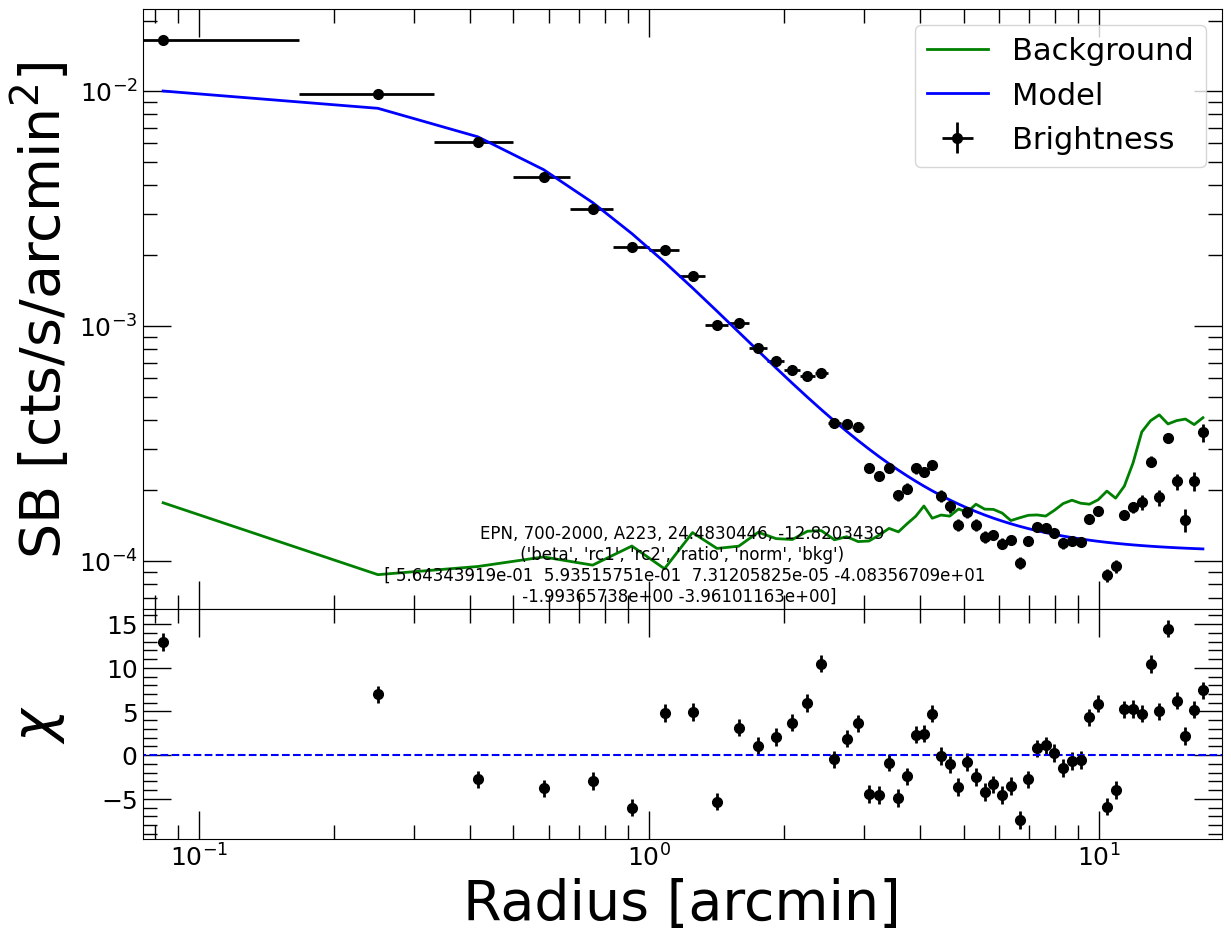

In [2]:
today = '2023-05-11'
maxrad = 20.
radec_lst = {'A222':[24.3941937, -12.9933436], "A223":[24.4830446, -12.8203439]}
doublebeta_para = {"700-1200":[0.6, 1, 7, 0.2, -2, -4], "1200-2000":[0.6, 1, 7, 0.2, -2, -4.2], "2000-5000":[0.6, 1, 7, 0.2, -2, -4], 
"5000-7000":[0.6, 1, 7, 0.2, -4, -4], "700-7000":[0.6, 1, 7, 0.2, -2, -2.5], "700-2000":[0.6, 1, 7, 0.2, -2, -4],
"2000-7000":[0.6, 1, 7, 0.2, -2.5, -4] , "1200-7000":[0.6, 1, 7, 0.2, -2, -4]}
for ins in ['EPIC', 'EMOS', 'EPN']:#,'xmm','chandra'
        # for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000', '700-7000', "700-2000", "2000-7000", "1200-7000"]:#, 
        for band in ['700-1200', '1200-7000', '2000-7000', '700-2000']:
            for clus in ['A222', 'A223']:
                ra = radec_lst[clus][0]
                dec = radec_lst[clus][1]

                img = f'{ins}_counts_{band}_{today}.fits'
                exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk.fits'
                # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk.fits'
                bkg = f'{ins}_bkg_{band}_{today}.fits'
                print(bkg)
                dat=pyproffit.Data(imglink=img, explink=exp, bkglink=bkg)
                prof=pyproffit.Profile(dat, center_choice='custom_fk5', center_ra = ra, center_dec =dec, maxrad=maxrad, binsize=10, binning='log')
                prof.SBprofile(ellipse_ratio=1)#, angle_low=80, angle_high=140)
                
                ### Double Beta
                mod=pyproffit.Model(pyproffit.DoubleBeta)
                beta, rc1,rc2, ratio, norm, bkg = doublebeta_para[band]
                fitobj=pyproffit.Fitter(model=mod, method='chi2', profile=prof, beta = beta, rc1 = rc1, rc2 =  rc2, ratio = ratio, norm = norm, bkg=bkg, fitlow=0.1, fithigh=maxrad)
                
                fitobj.Migrad()
                prof.Plot(model=mod)
                plt.title(f'{ins}, {band}, {clus}, {ra}, {dec}\n {mod.parnames} \n {mod.params}  ')

                # # inspecting results
                # # fitobj.minuit.minos()
                # #fitobj.minuit.draw_mncontour('beta', 'rc', cl=(0.68, 0.9, 0.99))
                os.makedirs(f'{workpath}/png/{int(maxrad)}am/{today}', exist_ok=True)
                os.makedirs(f'{workpath}/profiles/{int(maxrad)}am/{today}', exist_ok=True)
                plt.savefig(f'{workpath}/png/{int(maxrad)}am/{today}/{ins}_{clus}_{band}_noclfila.png')
                prof.Save(outfile=f"{workpath}/profiles/{int(maxrad)}am/{today}/{clus}_{ins}_{band}_doublebeta_profile_noclfila.fits", model=mod)

                

mask strange chip in A222 profile

In [ ]:
from glob import glob
today = '2023-05-08'
workpath = f'/Users/eusracenorth/Documents/suzaku_A222-223/xmm_data/merged/2023-05-07_merge_obs_inst_bands'
os.chdir(workpath)
f = open(f'{workpath}/masks/mask_eschipgap_big_A222_nofilamsk_{today}.sh', 'w')
f.write('#!/bin/bash\n')
for inst in ['EMOS', 'EPIC', 'EPN']:
    files = glob(f'{workpath}/{inst}_exp_*_edgemsk_srcmsk.fits')
    for file in files:
        f.write(f"ftimgcalc masks/{file.split('/')[-1].split('.')[0]}_bigeschipgapmsk.fits 'regfilter(\"masks/A222_eschip_gap_big.reg\",A.P1,A.P2) ? (0):(1)' a={file} clobber=yes\n")
        f.write(f"farith masks/{file.split('/')[-1].split('.')[0]}_bigeschipgapmsk.fits {file} {file.split('/')[-1].split('.')[0]}_bigeschipgapmasked.fits '*' clobber=yes\n")
f.close()



In [8]:
def basic_figure_style():
    SMALL_SIZE = 5*4                                       
    MEDIUM_SIZE = 8*2
    BIGGER_SIZE = 12*2

    # plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "sans-serif",
    # "font.sans-serif": "Helvetica",})
    plt.rc('font', size=BIGGER_SIZE, family='serif')          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)                    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
    plt.rc('lines', linewidth=4) 
    plt.rc('axes', grid=True) #
    plt.rc('grid', alpha=0.7) #
    plt.rc('xtick', top=True)
    plt.rc('ytick', right=True)
    plt.rc('axes.formatter', use_mathtext=True, min_exponent=4, useoffset=False)
    plt.rc('figure', figsize='6, 6')                         # size of the figure, used to be '4, 3' in inches
    ######################################################
basic_figure_style()


In [ ]:
from glob import glob
cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']
path = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230305'
xmmfiles = glob(f'{path}/*chan*0.7-1.2*doublebeta*10am*')
xmmfiles = np.sort(xmmfiles)
print(xmmfiles)
fig, axs = plt.subplots(2, len(xmmfiles), sharex=True, figsize=(len(xmmfiles)*10,8),gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0,wspace=0.2)
fig.align_ylabels()
for i, fname in enumerate(xmmfiles):
    hdul = fits.open(fname)
    dat = hdul[1].data 
    mdl = hdul[2].data
    model = DoubleBeta(dat['RADIUS'], mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4],  mdl['VALUE'][5])
    axs[0,i].errorbar(dat['RADIUS'], dat['SB'], yerr=dat['ERR_SB'], xerr=dat['WIDTH'], c = 'k', label = 'data', alpha=0.8,fmt = 'o')
    axs[0,i].plot(dat['RADIUS'], model, label = 'model', c = 'b')
    axs[0,i].plot(dat['RADIUS'], dat['BKG'], label = 'bkg', c = 'g')
    
    chi = (dat['SB'] - model) / dat['ERR_SB']
    axs[1,i].errorbar(dat['RADIUS'], chi, yerr=np.ones(len(dat['RADIUS'])),  c = 'k', label = 'data', alpha=0.8, fmt='o')
    axs[1,i].axhline(0, c='b', linestyle = '--')

    # axs[0,i].set_title(f'{fname.split("/")[-1]}')
    axs[0,i].set_yscale('log')
    # axs[0,i].set_ylim(1e-7,0.01)
    axs[1,i].set_yscale('linear')

for i in range(2):
    for j in range(len(xmmfiles)):
        axs[i,j].minorticks_on()
        axs[i,j].tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
        axs[i,j].tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
        axs[i,j].set_xlabel('Radius [arcmin]')
        axs[0,j].set_ylabel('SB [$\\rm cts/s/cm^2/arcmin^2$]')
        axs[1,j].set_ylabel('$\chi$')
axs[0,1].legend(frameon=False)
plt.xscale('log')
plt.yscale('linear')

# plt.savefig(f'{path}/pdf/{fnasplit("/")[-1].split(".fits")[0]}_A222left_A223right_sbprofile.pdf', dpi=300)
# print(f'{fname.split("/")[-1].splime.t(".fits")[0]}_A222left_A223right_sbprofile.pdf has been saved!')


make camel-like plot 
https://arxiv.org/pdf/2110.06224.pdf 

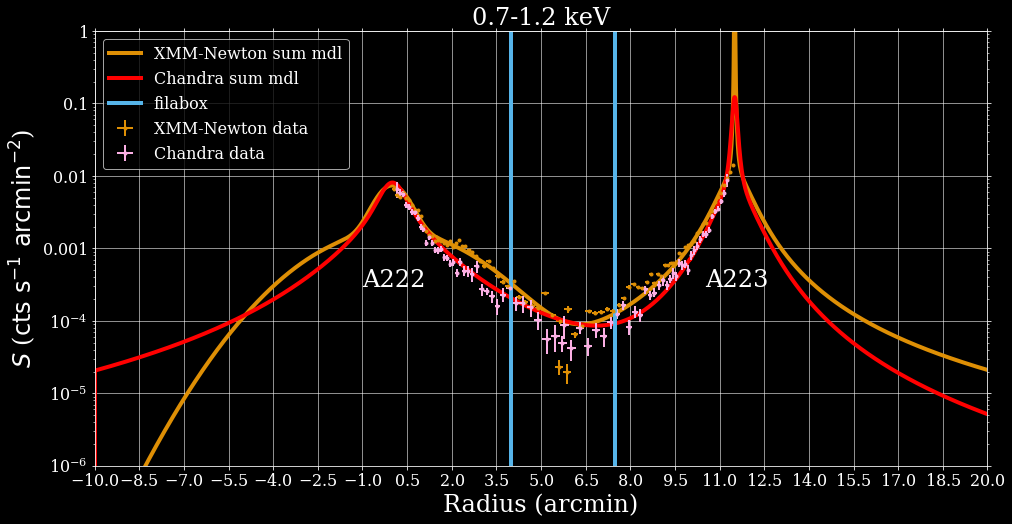

In [9]:
plt.style.use('dark_background')

from glob import glob
today = '2023-05-11'
chandra_path = '/stage/headat/yanling/chandra/results_230305'
xmm_path = f'{workpath}/profiles/10am/{today}'
savepath = f'{workpath}/png/camelplot'
os.makedirs(savepath, exist_ok=True)

cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']
chandra_Aeff = 100


def DoubleBeta_wobkg(x, beta, rc1, rc2, ratio, norm):
    out = np.power(10,norm) * (np.power(1 + (x / rc1) **2, -3 * beta + 0.5) + ratio * np.power(1 + (x / rc2) **2, -3 * beta + 0.5))
    return out
fig, ax = plt.subplots(figsize = (16,8))



## load xmm data

# xmm_skybg = np.array([0.0033413481427292846, 0.002563827590320338])
# skybg = xmm_skybg.min()#/3.08
# skybg = (1.77e-3+2*5.485e-4)/5*3/3.08
# plt.axhline(skybg)
x_mdl = np.arange(-10,11.5+10+0.01,0.01)
xmm_Aeff = 1 #400
fname = glob(f'{xmm_path}/*A222*EPIC*700-1200*doublebeta_profile_noclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
a222mdl = DoubleBeta_wobkg(np.arange(0,10,0.01), mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4])
y_a222mdl = np.concatenate((a222mdl[::-1], a222mdl))/xmm_Aeff
x_a222mdl = np.arange(-10,10, 0.01)
# plt.plot(x_a222mdl, y_a222mdl, c = 'g', alpha = 0.5)
msk = dat['RADIUS'] < 6
# plt.errorbar(dat['RADIUS'][msk], (dat['SB'][msk]-skybg)/xmm_Aeff, yerr=dat['ERR_SB'][msk]/xmm_Aeff, xerr=dat['WIDTH'][msk], c = cb[-5],fmt = 'o')

# plt.axhline(skybg/xmm_Aeff, label = '0', c = cb[0])
fname = glob(f'{xmm_path}/*A222*EPIC*700-1200*doublebeta_profile_inclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
plt.errorbar(dat['RADIUS'][msk], (dat['SB'][msk]-np.power(10, mdl['VALUE'][-1]))/xmm_Aeff, yerr=dat['ERR_SB'][msk]/xmm_Aeff, linewidth=2,xerr=dat['WIDTH'][msk], c = cb[1],fmt = '.')
xmm_Aeff = 1 #400
fname = glob(f'{xmm_path}/*A223*EPIC*700-1200*doublebeta_profile_noclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
a223mdl = DoubleBeta_wobkg(np.arange(0,10,0.01), mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4])
y_a223mdl = np.concatenate((a223mdl[::-1], a223mdl))/xmm_Aeff
x_a223mdl = np.arange(11.5-10,11.5+10, 0.01)
# plt.plot(x_a223mdl, y_a223mdl, c = 'g')
y_mdl = np.zeros(x_mdl.shape)
y_mdl[(x_mdl>(x_a222mdl[0]-0.01))&(x_mdl<=x_a222mdl[-1])] = y_a222mdl
y_mdl[(x_mdl>=x_a223mdl[0])&(x_mdl<(x_a223mdl[-1]+0.01))] += y_a223mdl
plt.plot(x_mdl, y_mdl,c = cb[1], linestyle = '-', label = 'XMM-Newton sum mdl')
msk = dat['RADIUS'] < 6

# plt.errorbar(11.5-dat['RADIUS'][msk], (dat['SB'][msk]-skybg)/xmm_Aeff, yerr=dat['ERR_SB'][msk]/xmm_Aeff, xerr=dat['WIDTH'][msk], c = cb[-5],fmt = 'o', label = 'xmm_wofila')

# plt.axhline(skybg/xmm_Aeff, label = '1', c = cb[1])
fname = glob(f'{xmm_path}/*A223*EPIC*700-1200*doublebeta_profile_inclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
plt.errorbar(11.5-dat['RADIUS'][msk], (dat['SB'][msk]-np.power(10, mdl['VALUE'][-1]))/xmm_Aeff, yerr=dat['ERR_SB'][msk]/xmm_Aeff, xerr=dat['WIDTH'][msk], c = cb[1],linewidth=2, label = 'XMM-Newton data',fmt = '.')

### load chandra models
fname = glob(f'{chandra_path}/*A222*chan*0.7-1.2*doublebeta*10am*')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data

# plt.errorbar(dat['RADIUS'], dat['SB']-np.power(10,mdl['VALUE'][5]), yerr=dat['ERR_SB'], xerr=dat['WIDTH'], c = cb[-2], fmt = 'o')

a222mdl = DoubleBeta_wobkg(np.arange(0,10,0.01), mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4])
y_a222mdl = np.concatenate((a222mdl[::-1], a222mdl))
x_a222mdl = (-10,10)


fname = glob(f'{chandra_path}/*A223*chan*0.7-1.2*doublebeta*10am*')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
# plt.errorbar(6 - dat['RADIUS'], dat['SB']-np.power(10,mdl['VALUE'][5]), yerr=dat['ERR_SB'], xerr=dat['WIDTH'], label = 'Chandra', c = cb[-2],fmt = 'o')

a223mdl = DoubleBeta_wobkg(np.arange(0,10,0.01), mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4])
y_a223mdl = np.concatenate((a223mdl[::-1], a223mdl))
x_a223mdl = (11.5-10,11.5+10)

x_mdl = np.arange(-10,11.5+10+0.01,0.01)
y_mdl = np.zeros(x_mdl.shape)
y_mdl[(x_mdl>x_a222mdl[0])&(x_mdl<=x_a222mdl[1])] = y_a222mdl
# plt.plot(x_mdl, y_mdl* chandra_Aeff,c = 'r', alpha = 0.5)
y_mdl = np.zeros(x_mdl.shape)
y_mdl[(x_mdl>=x_a223mdl[0])&(x_mdl<x_a223mdl[1])] = y_a223mdl
# plt.plot(x_mdl, y_mdl* chandra_Aeff,c = 'r', alpha = 0.5)
y_mdl = np.zeros(x_mdl.shape)
y_mdl[(x_mdl>x_a222mdl[0])&(x_mdl<=x_a222mdl[1])] = y_a222mdl
y_mdl[(x_mdl>=x_a223mdl[0])&(x_mdl<x_a223mdl[1])] += y_a223mdl
plt.plot(x_mdl, y_mdl* chandra_Aeff, c = 'r', linestyle = '-', label = 'Chandra sum mdl')

## load chandra data
# chan_skybg = np.array([1.563939922864141e-06, 1.7019209655102093e-06])
# skybg = chan_skybg.min()#/3.08 ##3.08 for0.7-1.2 keV
# skybg = 2.723e-4/5*3/3.08
# plt.axhline(skybg)
fname = glob(f'{chandra_path}/*A222*chandra*0.7-1.2*doublebeta_profile.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
# plt.errorbar(dat['RADIUS'][msk], (dat['SB'])[msk]* chandra_Aeff-skybg, yerr=dat['ERR_SB'][msk]* chandra_Aeff, xerr=dat['WIDTH'][msk], c = cb[-2],fmt = 'o')

fname = glob(f'{chandra_path}/*A222*chandra*0.7-1.2*doublebeta_profile_inclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
plt.errorbar(dat['RADIUS'][msk], (dat['SB'])[msk]* chandra_Aeff-np.power(10, mdl['VALUE'][-1]), yerr=dat['ERR_SB'][msk]* chandra_Aeff, xerr=dat['WIDTH'][msk],linewidth=2, c = cb[-4],fmt = '.')

fname = glob(f'{chandra_path}/*A223*chandra*0.7-1.2*doublebeta_profile.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
# plt.errorbar(11.5-dat['RADIUS'][msk], (dat['SB'])[msk]* chandra_Aeff-skybg, yerr=dat['ERR_SB'][msk]* chandra_Aeff, xerr=dat['WIDTH'][msk], c = cb[-2],label = 'chandra_wofila',fmt = 'o')

fname = glob(f'{chandra_path}/*A223*chandra*0.7-1.2*doublebeta_profile_inclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
plt.errorbar(11.5-dat['RADIUS'][msk], (dat['SB'])[msk]* chandra_Aeff-np.power(10, mdl['VALUE'][-1]), yerr=dat['ERR_SB'][msk]* chandra_Aeff, xerr=dat['WIDTH'][msk], c = cb[-4],linewidth=2, label = 'Chandra data ',fmt = '.')
plt.ylim(1e-6,1)
plt.xlim(-8,20)
plt.text(10.5,3e-4, 'A223')
plt.text(-1,3e-4, 'A222')
plt.axvline(4, c= cb[-1])
plt.axvline(4+3.5, c = cb[-1], label = 'filabox')
plt.yscale('log')
plt.ylabel('$S$ ($\\rm cts\ s^{-1}\ arcmin^{-2}$)')
plt.xlabel('Radius (arcmin)')
plt.legend()
plt.xticks(np.arange(-10, 11.5+10,1.5))
plt.title('0.7-1.2 keV', fontsize=24)
plt.savefig(f'{savepath}/camel-poster.png', dpi=600)

In [ ]:
np.power(10, mdl['VALUE'[-1]])

# plot vignetted-corrected, bkg-subtracted plots for sanity check

scale PN exp map

In [ ]:
PN_scaling  = {'700-1200': , '700-2000': , 
'700-7000': , '2000-7000': , '5000-7000': , 
'2000-5000': , '1200-7000': , '1200-2000': }

make maps

In [ ]:
datapath2 = f'/Users/eusracenorth/Documents/suzaku_A222-223/xmm_data/merged/2023-05-07_merge_obs_inst_bands'
datapath1 = f'/Users/eusracenorth/Documents/suzaku_A222-223/xmm_data/merged/2023-05-10'
savepath = f'{datapath1}/images'
os.makedirs(savepath, exist_ok=True)

today = '2023-05-10'
maxrad = 10.
os.chdir(datapath1)
os.system(f'cp {datapath2}/*_exp*_edgemsk_srcmsk.fits {datapath1}')
radec_lst = {'A222':[24.3941937, -12.9933436], "A223":[24.4830446, -12.8203439]}
doublebeta_para = {"700-1200":[0.6, 1, 7, 0.2, -2, -3], "1200-2000":[0.6, 1, 7, 0.2, -2, -3.2], "2000-5000":[0.6, 1, 7, 0.2, -2, -3], 
"5000-7000":[0.6, 1, 7, 0.2, -3, -3], "700-7000":[0.6, 1, 7, 0.2, -2, -2.5], "700-2000":[0.6, 1, 7, 0.2, -2, -3],
"2000-7000":[0.6, 1, 7, 0.2, -2.5, -3] , "1200-7000":[0.6, 1, 7, 0.2, -2, -3]}
f = open(f'{savepath}/create_images.sh', 'w')

for ins in ['EPIC', 'EMOS','EPN']:#,'xmm','chandra'
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000', '700-7000', "700-2000", "2000-7000", "1200-7000"]:#, 
            for clus in ['A222', 'A223']:
                ra = radec_lst[clus][0]
                dec = radec_lst[clus][1]

                img = f'{ins}_cts_{band}_{today}.img'
                # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk_bigeschipgapmasked.fits'
                # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk.fits'
                exp = f'{ins}_exp_{band}_*_edgemsk_srcmsk.fits'
                bkg = glob(f'{ins}_bkg_{band}_{today}.img')[0]
                f.write(f'farith {img} {bkg} {img.split(".")[0]}_net.fits "-" clobber=yes\n')
                f.write(f'fimgtrim infile={img.split(".")[0]}_net.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_net_trimmed.fits clobber=yes\n')
                f.write(f'farith {img.split(".")[0]}_net_trimmed.fits {exp} {img.split(".")[0]}_net_ctr.fits "/" clobber=yes\n')
                f.write(f'fimgtrim infile={img.split(".")[0]}_net_ctr.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_net_ctr_trimmed_nogapmsk.fits clobber=yes\n')
f.close()




imshow and save the figures

In [ ]:
# from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
import numpy as np
kernel = Gaussian2DKernel(x_stddev=1)
# 'EPN_corr_counts'
#EMOS1_obs101_bkg_clean_2023-05-04_1200-2000_scaled.img
data_dir = '/stage/headat/yanling/xmm/reduction_230227/101'
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
title = 'EPN_obs201_bkg_clean_2023-05-10_2000-5000_scaled_corr'
file = f"{bkg_dir}/{title}"
hdu = fits.open(f'{file}.img')[0]
image_data = hdu.data
print(image_data.shape)
fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}.img'))
ra = ax.coords[0]
dec = ax.coords[1]
# plt.grid(color='grey', ls='dashed')
plt.grid('off')
ra.set_axislabel('RA')
dec.set_axislabel('Dec')
image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
astropy_conv = convolve(image_data, kernel)
plt.title(title)
plt.imshow(astropy_conv[50:650,50:550], cmap='gnuplot2', norm = colors.LogNorm(), origin='lower')
plt.colorbar()
plt.savefig(f'{file}.png')
plt.show()
plt.clf()
